# Support Vector Machine Solvers

### Description

Given $m$ data points $x_i \in \mathbb{R}^n$ with labels $y_i \in \{−1, 1\}$. We aim to solve 
the classification problem 

\begin{align}
\mathrm{minimize} \enspace & \frac{1}{2} \lVert w\rVert_2^2 + C\mathbf{1}^\top z
    \hspace{2cm}\\
\mathrm{subject\thinspace to} \enspace & y_i(w^\top x_i) \ge 1-z_i, i = 1, ..., m
    \hspace{2cm}\\
& z \ge 0
\end{align}

in the variables $w \in \mathbb{R}^n, z \in \mathbb{R}^m$, and its dual. Solving this problem trains a classifier vector $w$ such that, up to some errors

\begin{align}
w^\top x_i > 0 &\enspace \mathrm{when}\enspace y_i = 1 \\
w^\top x_i < 0 &\enspace \mathrm{when}\enspace y_i = −1.
\end{align}

This classifier can then be used to classify new points $x$ as positives or negatives by simply computing the scalar product $w^\top x$.

### Dual

We can also form the dual problem

\begin{align}
\mathrm{maximize} \enspace & 
    -\frac{1}{2} \lVert \sum_{i=1}^m \alpha_i y_i x_i\rVert_2^2 + \mathbf{1}^\top \alpha
    \hspace{2cm}\\
\mathrm{subject\thinspace to} \enspace & 0 \le \alpha \le C
    \hspace{2cm}
\end{align}

in the variable $\alpha\in\mathbb{R}^m$.

Solving the dual problem solves the primal problem at the same time since we know that at the optimum, we must have

$$ w = \sum_{i=1}^m \alpha_i y_i x_i.$$

If we note $X$ the data matrix with rows $x_i$, the dual can then be written as

\begin{align}
\mathrm{maximize} \enspace & 
    -\frac{1}{2} \alpha^{\top}\mathrm{diag}(y)XX^{\top}\mathrm{diag}(y)\alpha
    + \mathbf{1}^\top \alpha
    \hspace{2cm}\\
\mathrm{subject\thinspace to} \enspace & 0 \le \alpha \le C.
    \hspace{2cm}
\end{align}

The data only appears through the matrix $XX^T$. We are thus able to solve the dual by the kernel tricks. This is particularly useful when the dimension $n$ of the feature space is very high.

### Barrier Method

At each centering step we want to minimize the function $tf + \phi$ where

\begin{align}
f &= \frac{1}{2} \lVert w\rVert_2^2 + C\mathbf{1}^\top z, \\
\phi &= -\sum_{i=1}^m(\log(y_i(w^\top x_i)+z_i-1) + \log(z_i)).
\end{align}

We need thus to compute its gradient and Hessian for each Newton step. The detailed implementation can be found in the file `barrier.jl`. To test the algoritm, I'll sample data from two bivariate Gaussian distributions with different moments. Some useful functions are defined in `common.jl`.

In [1]:
using Distributions
using Plots
pyplot()

include("barrier.jl")
include("common.jl")

plotdualitygap (generic function with 1 method)

#### A first example

Start with an easy example where the generated data for the two classes have high probability to be linearly separable.


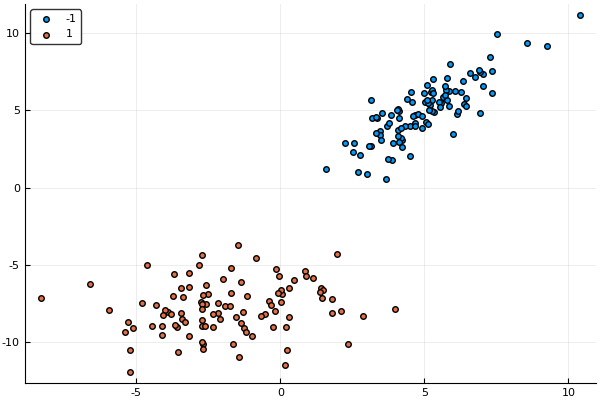

In [2]:
numdatapoints = 100
gaussianA = MvNormal([5.; 5.], [2. 2.; 2. 3.])
gaussianB = MvNormal([-2.; -8.], [5. 1.; 1. 3.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)


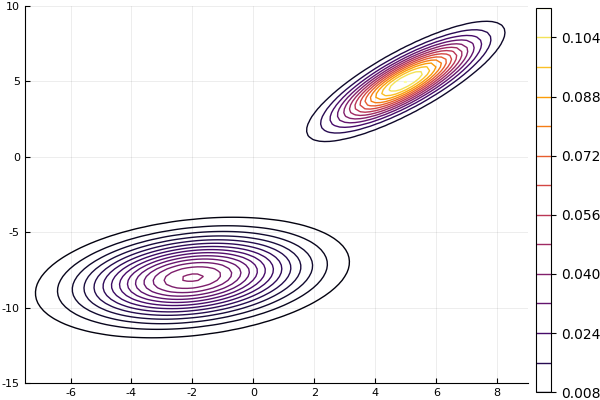

In [3]:
xs = linspace(-7.5, 9, 100)
ys = linspace(-15, 10, 100)
contour(xs, ys, (x, y) -> pdf(gaussianA, [x; y]))
contour!(xs, ys, (x, y) -> pdf(gaussianB, [x; y]))

Compute the line that separates the two classes of data and plot duality gap versus iteration number.

In [4]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
w, α, numstepsarray = svmbarrier(X, Y, 10, 1e-4)

([-0.245734, -0.381294, -0.161553], [2.87284e-9, 2.70197e-9, 2.13014e-9, 4.22334e-9, 3.22779e-9, 2.98409e-9, 3.86434e-9, 2.6467e-9, 3.30855e-9, 2.86363e-9  …  2.64903e-9, 2.85722e-9, 2.42208e-9, 4.61855e-9, 4.99432e-9, 3.47259e-9, 2.24234e-9, 2.6044e-9, 3.42269e-9, 4.0803e-9], [40, 35, 70, 26, 21])


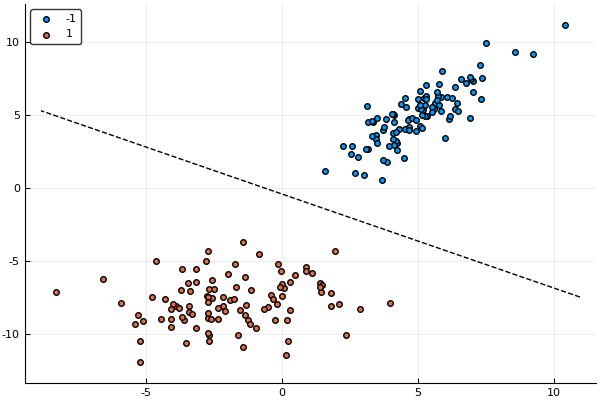

In [5]:
plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)


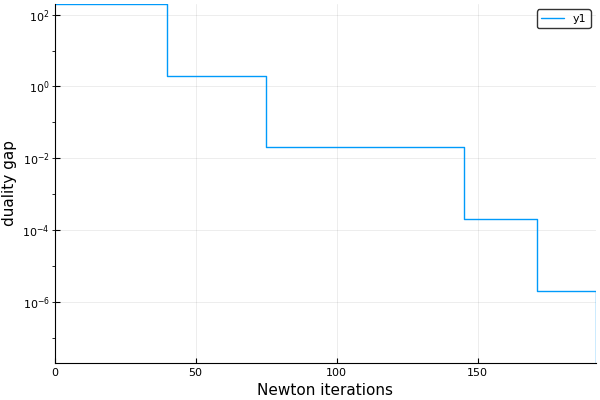

In [6]:
plotdualitygap(2*numdatapoints, 100., numstepsarray)

Well, this is indeed the ideal curve supposing that for each value of $t$ we're able to get the true optimum of the funtion. This is apparently not the case and when $t$ gets larger it becomes often more and more difficult to find a better solution. Therefore if we compute the real duality gap from the $x$ and $\alpha$ that we obtained, we get something that's much bigger than $10^{-6}$.

In [7]:
C = 10
Q = Diagonal(Y)*X*X'*Diagonal(Y)
primal(w) = sum(w.^2)/2 + C*sum(max.(0, ones(Y)-Y.*(X*w)))
dual(α) = -α⋅(Q*α)/2 + sum(α)

primal(w) - dual(α)

0.11593431389296435

Run the algorithm with different values of $C$ and measure out-of-sample performance. However, probably since the problem to solve is too easy here, we don't see a great different between the use of different $C$s.

In [8]:
for C in [1e-5, 1e-3, 1, 10, 100, 1000]
    w, α, numstepsarray = svmbarrier(X, Y, C, 1e-4)
    println("When C = $C, the error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
end

When C = 1.0e-5, the error rate is 0.000717
When C = 0.001, the error rate is 0.000736
When C = 1.0, the error rate is 0.000528
When C = 10.0, the error rate is 0.000505
When C = 100.0, the error rate is 0.000548
When C = 1000.0, the error rate is 0.000547


#### Example 2

Now try with another example where the generated data are most of the time not linearly separable.


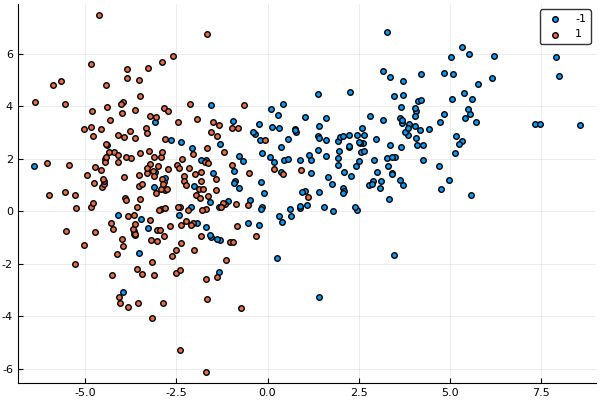

In [9]:
numdatapoints = 200
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)


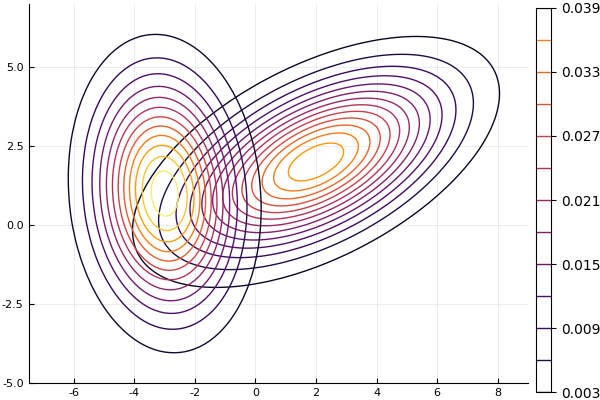

In [10]:
xs = linspace(-7.5, 9, 100)
ys = linspace(-5, 7, 100)
contour(xs, ys, (x, y) -> pdf(gaussianA, [x; y]))
contour!(xs, ys, (x, y) -> pdf(gaussianB, [x; y]))


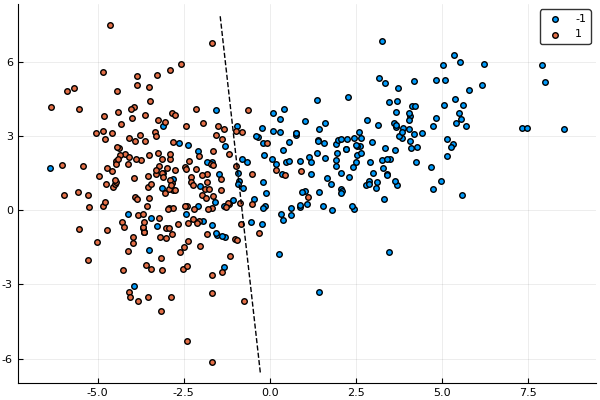

In [11]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
w, α, numstepsarray = svmbarrier(X, Y, 100, 1e-4)

plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)


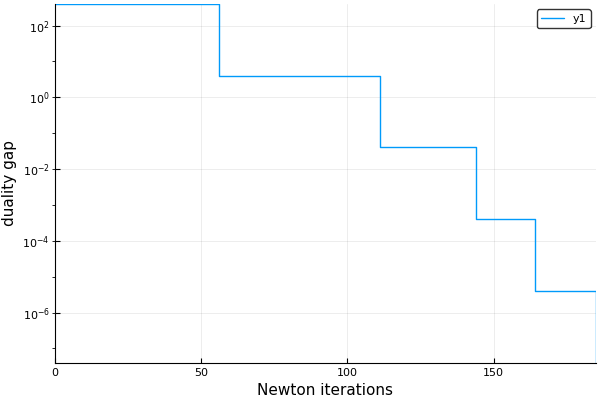

In [12]:
plotdualitygap(2*numdatapoints, 100., numstepsarray)

In [13]:
for C in [1e-5, 1e-3, 1, 10, 100, 1000]
    w, α, numstepsarray = svmbarrier(X, Y, C, 1e-4)
    println("When C = $C, the error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
end

When C = 1.0e-5, the error rate is 0.224414
When C = 0.001, the error rate is 0.226073
When C = 1.0, the error rate is 0.204075
When C = 10.0, the error rate is 0.205393
When C = 100.0, the error rate is 0.205059
When C = 1000.0, the error rate is 0.204657


Again, we still don't see great differences in term of the performance when different value of $C$ is chosen, but the results seems to suggest that greater the $C$, better the separating line we'll get. In fact, $C$ measures the penalization of misclassifiying a point and choosing a $C$ sufficiently large yields the hard-margin classifier for linearly separable data.

Nonetheless, it's also well-known that large $C$ leads often to overfitting of the training data. This can be seen for some extremly cases in this setting.


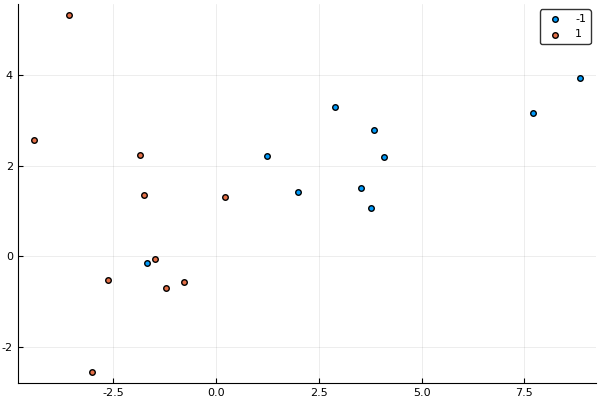

In [126]:
numdatapoints = 10
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)


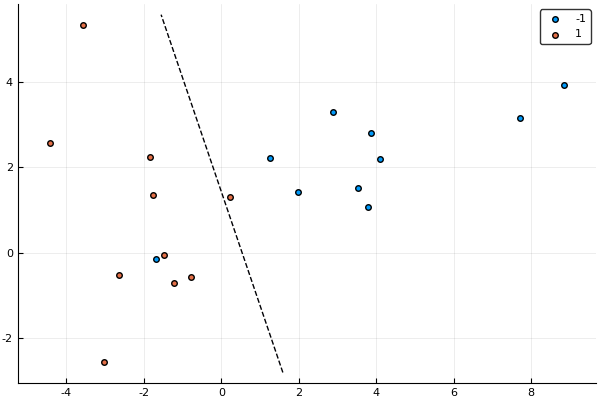

In [127]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
w, α, numstepsarray = svmbarrier(X, Y, 100, 1e-4)

plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)

In [128]:
for C in [1e-5, 1e-3, 1, 10, 100, 1000]
    w, α, numstepsarray = svmbarrier(X, Y, C, 1e-4)
    println("When C = $C, the error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
end

When C = 1.0e-5, the error rate is 0.224978
When C = 0.001, the error rate is 0.225979
When C = 1.0, the error rate is 0.2563
When C = 10.0, the error rate is 0.256342
When C = 100.0, the error rate is 0.257288
When C = 1000.0, the error rate is 0.256486


As predicted, since we have few training data here. When they fail to describe properly the underlying model a large value of $C$ can cause overfitting and thus deteriorate the out-of-sample performance of the classifier. In contrast, choosing a small value of $C$ (in this case samller than $10^{-3}$) sometimes allows us to get around this problem.

### Compare with Different Solvers

In this section I'll try to use some off-the-shelf solvers to solve the classification problem and compare their performances with the previous implementation. I'll continue to use the previous example for the tests.


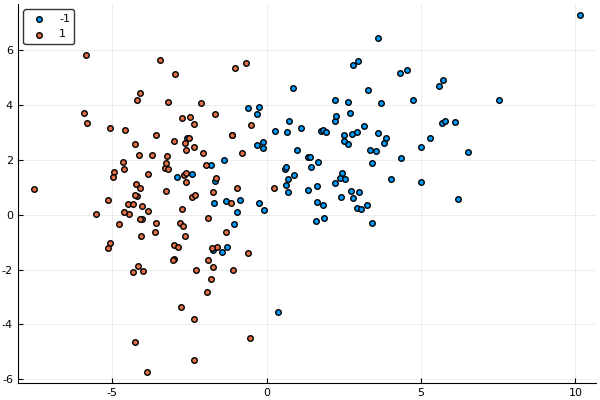

In [49]:
numdatapoints = 100
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)

X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
plotclouds(cloudA, cloudB)

#### IPOPT

In Julia, the `JuMP` package allows us to interact with many optimization backends a uniform syntax. Among the open source solvers that support quadratic programming, there is notably **IPOPT (Interior Point OPTimizer)** which I choose to use here. To compare the performances, I'll fix $C=1$ and $\epsilon=10^{-3}$ (tolerance of termination critirion).

In [54]:
using JuMP
using Ipopt

model = Model(solver=IpoptSolver(tol=0.001))
C = 1

@variables model begin
    w[1:3]
    z[1:2*numdatapoints], (lowerbound=0)
end

@objective(model, Min, sum(w.^2)/2+C*sum(z))
@constraint(model, con, Y.*X*w .≥ 1 - z)

status = solve(model)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

:Optimal

The error rate is 0.207202
The duality gap is 0.0021073315363935308.



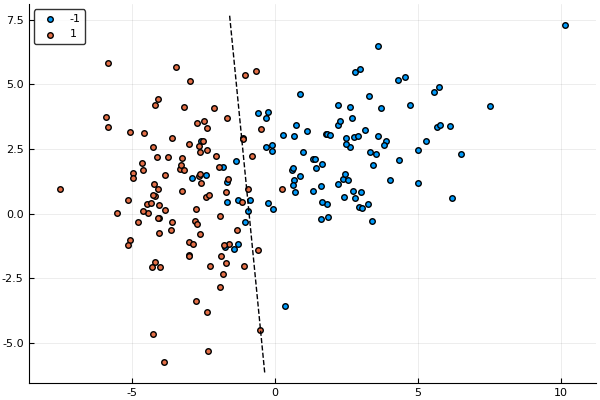

In [55]:
Q = Diagonal(Y)*X*X'*Diagonal(Y)
primal(w) = sum(w.^2)/2 + C*sum(max.(0, ones(Y)-Y.*(X*w)))
dual(α) = -α⋅(Q*α)/2 + sum(α)

println("The error rate is $(errorrate(gaussianA, gaussianB, getvalue(w), Int(1e6)))")
println("The duality gap is $(primal(getvalue(w)) - dual(getdual(con))).")
plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅getvalue(w))

#### Benchmarking, LIVSVM

I'll now suppress output of the solver in order to do some benchmark.

In [56]:
using BenchmarkTools

model = Model(solver=IpoptSolver(tol=0.001, print_level=0))
C = 1

@variables model begin
    w[1:3]
    z[1:2*numdatapoints], (lowerbound=0)
end

@objective(model, Min, sum(w.^2)/2+C*sum(z))
@constraint(model, con, Y.*X*w .≥ 1 - z)

@benchmark solve($model)

BenchmarkTools.Trial: 
  memory estimate:  168.63 KiB
  allocs estimate:  1719
  --------------
  minimum time:     9.878 ms (0.00% GC)
  median time:      10.233 ms (0.00% GC)
  mean time:        10.537 ms (0.25% GC)
  maximum time:     35.330 ms (12.41% GC)
  --------------
  samples:          475
  evals/sample:     1

A famous library knowing for solving SVM problems is clearly **libsvm**. SVR servers as the Julia interface of it (the default $C$ and $\epsilon$ match the values that I choose).

In [50]:
import SVR

X_ = X[:, 1:2]'
@benchmark SVR.train($Y, $X_, svm_type=Int32(0), kernel_type=Int32(0))

BenchmarkTools.Trial: 
  memory estimate:  12.39 KiB
  allocs estimate:  30
  --------------
  minimum time:     379.290 μs (0.00% GC)
  median time:      390.477 μs (0.00% GC)
  mean time:        401.100 μs (0.34% GC)
  maximum time:     3.278 ms (82.05% GC)
  --------------
  samples:          10000
  evals/sample:     1

Since with the Julia interface of **libsvm**, it's quite painful to get the value of the support vector (dealing with C pointers etc.), I just show here that the classification performance is comparable with what we has been seen before.

In [53]:
numtestpoints = 10000
testA = rand(gaussianA, numtestpoints)
testB = rand(gaussianB, numtestpoints)
Xtest = [testA testB]
Ytest = [-1.*ones(numtestpoints); ones(numtestpoints)]

model = SVR.train(Y, X_, svm_type=Int32(0), kernel_type=Int32(0))
predict(x) = SVR.predict(model, x)
sum(mapslices(predict, Xtest, 1)'.≠Ytest)/numtestpoints

0.2042

Finally I test my own implementation which is of course not optimized at all.

In [57]:
@benchmark svmbarrier(X, Y, 1, 1e-3)

BenchmarkTools.Trial: 
  memory estimate:  865.50 MiB
  allocs estimate:  201981
  --------------
  minimum time:     576.625 ms (13.25% GC)
  median time:      728.240 ms (10.35% GC)
  mean time:        724.604 ms (10.47% GC)
  maximum time:     869.239 ms (8.97% GC)
  --------------
  samples:          7
  evals/sample:     1

#### Analysis

We see that **libsvm** is $10$ to $100$ times faster than **IPOPT** while **IPOPT** is still about $100$ times faster than my own implementation.

What I implemented is a naif barrier method for which at each centering step we need to compute the Hessian (a matrix of size $(n+m) \times (n+m)$) and its inverse. The algorithm becomes extremely slow and even intractable when the value of $m$ grows.

Without knowing the details, it seems that **IPOPT** implements a primal-dual interior point method and exploits both first and second derivative information. However it is still quite efficient despite the use of Hessian and I think there are certainly also improvements that can be carried out for the barrier method to get something that runs faster.

Finally, **libsvm** of course uses the algorithm that adpats the best to the problem (it seems that dual coordinate descent is used for linear SVM) and has the best performance. Now let's try with more data points.


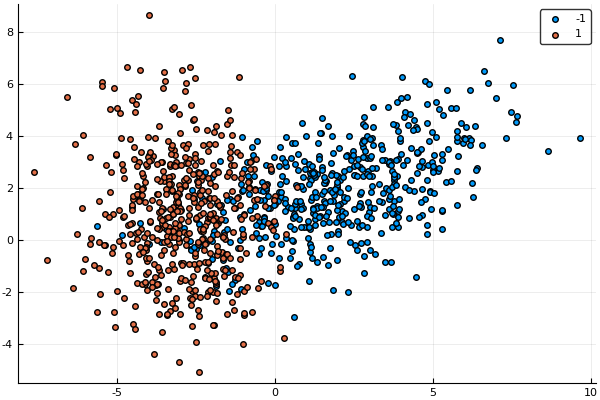

In [58]:
numdatapoints = 500
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)

X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
plotclouds(cloudA, cloudB)

In [59]:
model = Model(solver=IpoptSolver(tol=0.001, print_level=0))
C = 1

@variables model begin
    w[1:3]
    z[1:2*numdatapoints], (lowerbound=0)
end

@objective(model, Min, sum(w.^2)/2+C*sum(z))
@constraint(model, con, Y.*X*w .≥ 1 - z)

@benchmark solve($model)

BenchmarkTools.Trial: 
  memory estimate:  857.64 KiB
  allocs estimate:  13849
  --------------
  minimum time:     51.871 ms (0.00% GC)
  median time:      55.007 ms (0.00% GC)
  mean time:        54.422 ms (0.20% GC)
  maximum time:     63.486 ms (5.43% GC)
  --------------
  samples:          92
  evals/sample:     1

In [62]:
X_ = X[:, 1:2]'
@benchmark SVR.train($Y, $X_, svm_type=Int32(0), kernel_type=Int32(0))

BenchmarkTools.Trial: 
  memory estimate:  56.02 KiB
  allocs estimate:  31
  --------------
  minimum time:     8.719 ms (0.00% GC)
  median time:      8.888 ms (0.00% GC)
  mean time:        8.903 ms (0.04% GC)
  maximum time:     11.328 ms (19.30% GC)
  --------------
  samples:          562
  evals/sample:     1

In [60]:
@time svmbarrier(X, Y, 1, 1e-3)

 27.430892 seconds (224.51 k allocations: 21.712 GiB, 31.80% gc time)


([-0.839439, -0.0470739, -0.664762], [-3.70701e-9, 3.07092e-9, 2.41016e-9, 2.45194e-9, 1.93825e-9, 7.92054e-9, 3.60433e-8, 4.13643e-9, -9.6573e-9, 4.76845e-9  …  -6.79658e-8, 5.3273e-9, 2.70813e-9, -1.39386e-8, 1.05899e-8, 7.83716e-9, 1.15468e-8, 1.32736e-8, 1.13849e-8, 1.38783e-8], [15, 181, 69, 25, 21])

### Coordinate Descent

As shown above, a direct implementation of barrier method is not very efficient. We can address the problem from its dual, which has a boxed constraint and can be efficiently solved by coordinate descent. The primal solution is later recovered thanks to the representer theorem. The implementation of this method can be found in the file `dualcoordinatedescent.jl`.

In [126]:
include("dualcoordinatedescent.jl")

svm_dualcoordinatedescentopt (generic function with 3 methods)

#### Give a first try

The coordinate descent process is composed of a series of outer iterations while each outer iteration contains $m$ inter iterations. In each inter iteration, we try to minimize the function along a particular coordinate. In my fisrt implementation, I compute the duality gap after every outer iteration to see if the stopping critirion is met.


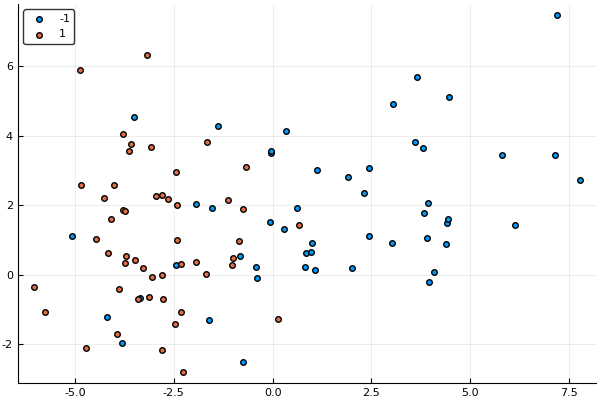

In [68]:
numdatapoints = 50
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)

In [69]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
@time w, α, dualitygaps = svm_dualcoordinatedescent(X, Y, 10, 1, 5000)

  0.169160 seconds (1.32 M allocations: 280.531 MiB, 20.29% gc time)


([-0.605869, -0.0557164, -0.573438], [0.0, 10.0, 0.0, 0.0, 10.0, 4.89995, 0.0, 10.0, 10.0, 10.0  …  0.0, 10.0, 10.0, 10.0, 0.0, 0.0, 10.0, 10.0, 0.0, 0.0], [1.61162e6, 6160.67, 2597.63, 1245.01, 622.255, 327.714, 200.621, 186.071, 185.065, 184.03  …  1.5222, 1.52127, 1.52034, 1.5194, 1.51847, 1.51754, 1.5166, 1.51567, 1.51474, 0.322292])

The error rate is 0.207995



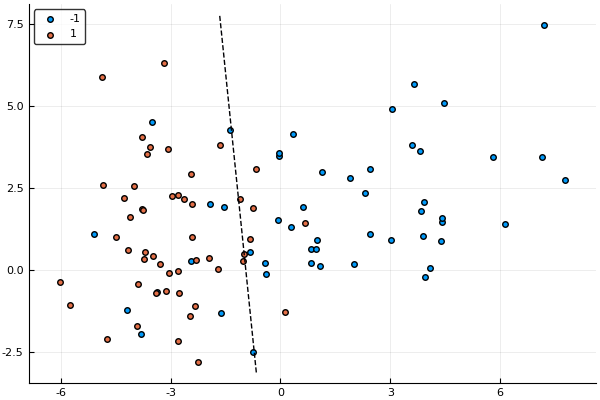

In [73]:
println("The error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)


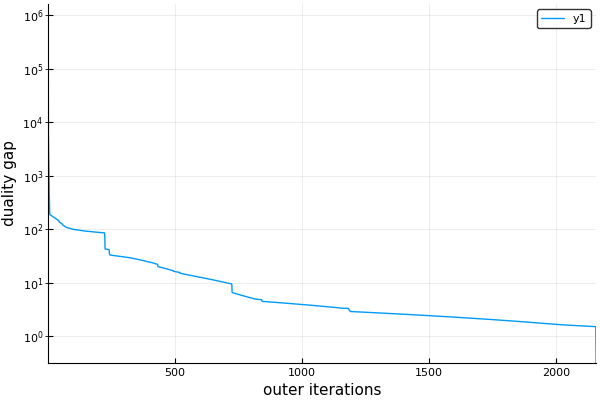

In [70]:
plot(dualitygaps, yscale=:log10, xlabel="outer iterations", ylabel="duality gap")

The convergence is slow comparing with the barrier mathod, in the sense that a lot more iterations are needed. In theory, the convergence should be linear, but in practice when we add more data points, as shown in the case below, the algorithm may fail to converge (or may take very long time to converge) and that's why I need to add `maxiter` as an argument. We notice however that if we compute the real duality gap this algorithm achieves a better precision than the barrier method.

In [103]:
numdatapoints = 500
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)

X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
@time w, α, dualitygaps = svm_dualcoordinatedescent(X, Y, 10, 1, 10000)

 48.531676 seconds (69.89 M allocations: 80.119 GiB, 19.10% gc time)


([-0.766031, 0.0242007, -0.612323], [10.0, 6.51962, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 1.76816], [1.88279e8, 3.52834e5, 1.41607e5, 60789.5, 34254.8, 18742.2, 10438.6, 5803.28, 3025.56, 1701.44  …  7.60056, 7.59692, 7.59327, 7.58962, 7.58597, 7.58233, 7.57784, 7.57329, 7.56875, 7.5642])


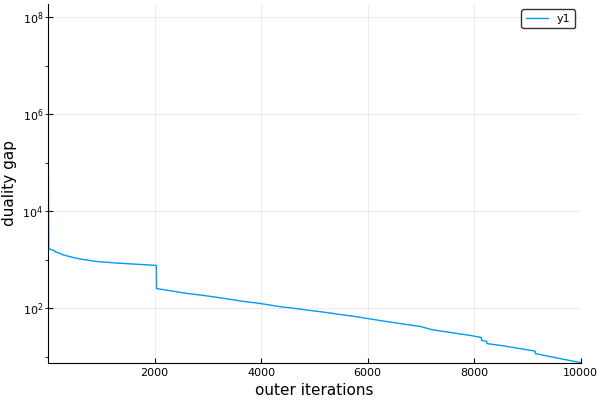

In [121]:
plot(dualitygaps, yscale=:log10, xlabel="outer iterations", ylabel="duality gap")

In [111]:
@time wb, αb, numstepsarray = svmbarrier(X, Y, 10, 1)

 17.535010 seconds (162.54 k allocations: 13.462 GiB, 30.69% gc time)


([-0.765615, 0.0296151, -0.615745], [-0.000848658, 0.000101956, 2.13611e-5, 2.44687e-5, 3.32447e-5, 6.10169e-5, 4.66675e-5, 6.7928e-5, 0.000255948, 3.00574e-5  …  4.03647e-5, 8.07755e-5, 3.44764e-5, 5.38487e-5, 4.44199e-5, 0.0128685, 5.07133e-5, 5.28508e-5, 4.965e-5, 9.64512e-5], [48, 97, 48])

In [113]:
Q = Diagonal(Y)*X*X'*Diagonal(Y)
primal(w) = sum(w.^2)/2 + 10*sum(max.(0, ones(Y)-Y.*(X*w)))
dual(α) = -α⋅(Q*α)/2 + sum(α)
primal(wb) - dual(αb)

2620.63781775004

Strangely it may seem that the barrier method is faster but they're not comparable because as we can see we don't have the same level of precision. Besides, the dual coordinate descent can in fact be more efficient by modifying a little bit the implementation.

#### Some ameliorations

The function `svm_dualcoordinatedescentopt` is another implementation of the dual coordinate descent method. We apply random permutation of descent orders to each outer iteration. The partial derivative can be computed more efficiently in time $O(n)$ rather than $O(m)$ which is a great improvement when $m \gg n$. Finally computing the duality gap after each outer iteration is expensive, but to solve this problem other stopping criterion should be found. I will not address this issue here and therefore I simply give the number of outer iterations to run as an argument.

In [130]:
@time wopt, αopt = svm_dualcoordinatedescentopt(X, Y, 10, 10000)

  1.498702 seconds (35.79 M allocations: 2.823 GiB, 23.56% gc time)


([-0.765405, 0.0298089, -0.616142], [10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0])

In [131]:
primal(wopt) - dual(αopt)

0.011950684528528654

The error rate is 0.206026



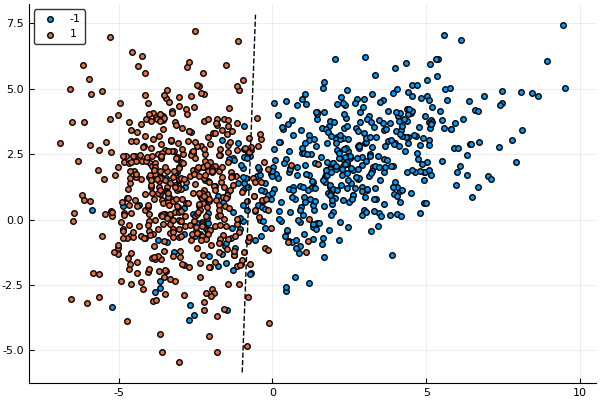

In [132]:
println("The error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)

We see that the algorithm is now much faster and has a better precision.